In [96]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.3}".format
np.set_printoptions(formatter={"float_kind": float_formatter})


In [191]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


with sqlite3.connect("games") as con:
    con.row_factory = dict_factory
    # new
    # res = con.execute(
    #     """
    #     SELECT
    #         g.result,
    #         g.elo_white,
    #         g.elo_black,
    #         p.eval,
    #         p.ply
    #         -- p.material_white - m.material_black as balance
    #     FROM
    #         games g INNER JOIN positions p
    #         ON g.rowid = p.game_id
    #     WHERE
    #         g.result != 3
    #         AND p.eval is not NULL
    #         AND p.eval < 9900
    #         AND p.eval > -9900
    #     """
    # )

    query1 = """
        SELECT 
            g.result,
            m.eval,
            m.ply
        FROM 
            games g INNER JOIN moves m 
            ON g.url = m.url
        WHERE
            g.result != 3
            AND m.eval is not NULL
            AND m.eval < 9900
            AND m.eval > -9900
        """



    query2 = """
        SELECT 
            g.result,
            MIN(m.eval) as eval_min,
            MAX(m.eval) as eval_max,
            AVG(m.eval) as eval_avg
        FROM 
            games g INNER JOIN moves m 
            ON g.url = m.url
        WHERE
            g.result != 3
            AND m.eval is not NULL
            AND m.eval < 9900
            AND m.eval > -9900
        GROUP BY g.url
        """

    res = con.execute(query1)
    df = pd.DataFrame(res)

con.close()


In [194]:
random_state = 42

features = ["eval", "ply"]
# features = ["eval_min", "eval_max"]
X = df.loc[:, features]
y = df.result

classifier = LogisticRegressionCV(
    # Cs=50,
    random_state=random_state,
    n_jobs=-1,
    # penalty="elasticnet",
    # solver="saga",
    # l1_ratios=np.linspace(0, 1, num=20),
    # class_weight="balanced",
)
scaler = StandardScaler()
model = make_pipeline(scaler, classifier)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_state, stratify=y
)


c:\tools\miniconda3\envs\py310\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


<AxesSubplot: xlabel='ply', ylabel='eval'>

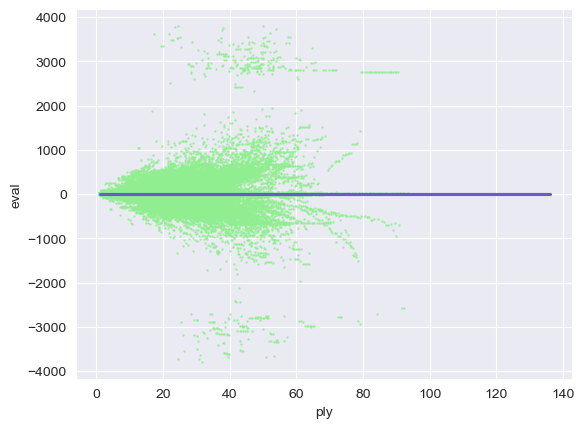

In [206]:
sns.regplot(
    data=(df + 1) / 2,
    x="ply",
    y="eval",
    y_jitter=0.05,
    x_jitter=0.2,
    logistic=True,
    n_boot=1,
    ci=1,
    scatter_kws={"s": 0.5, "color": "lightgreen"},
    color="slateblue",
)


In [199]:
model.fit(X_train, y_train)

print(f"Accuracy: \n {model.score(X_test, y_test)}")
coefs = (
    model.named_steps["logisticregressioncv"].coef_
    / model.named_steps["standardscaler"].scale_
)
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["logisticregressioncv"].coef_
print(f"Intercept: \n {intercept}")

cs = model.named_steps["logisticregressioncv"].C_
cs


Accuracy: 
 0.5937178166838311
Coefficients: 
 [[-0.00172 -0.00953]
 [-6.79e-05 0.018]
 [0.00179 -0.00845]]
Intercept: 
 [[-1.23 -0.3]
 [-0.0483 0.567]
 [1.27 -0.266]]


array([2.78, 2.78, 2.78])

In [200]:
# sns.scatterplot(
#     df,
#     x="ply",
#     y="eval",
#     hue="result",
#     s=3,
#     palette="Set1",
# )


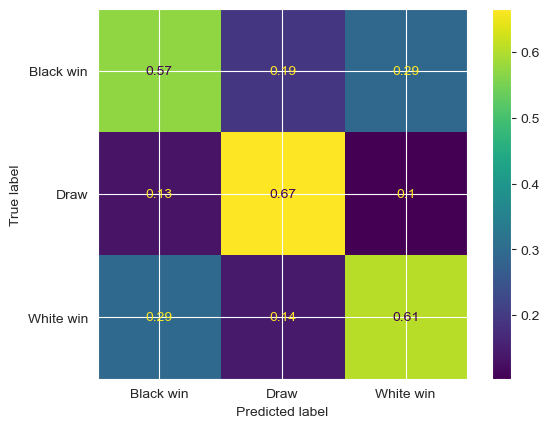

In [201]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    normalize="pred",
    display_labels=[
        "Black win",
        "Draw",
        "White win",
    ],
)


In [202]:
model.predict_proba([[0, 0]])

c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.496, 0.0561, 0.448]])

In [205]:
model.predict_proba([[-500, 100]])

c:\tools\miniconda3\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.513, 0.397, 0.0893]])